In [1]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import matplotlib

from IPython.display import Image, display
from typing import Union

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 8)

/home/george/miniconda3/envs/lucid/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/george/miniconda3/envs/lucid/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/george/miniconda3/envs/lucid/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/george/miniconda3/envs/lucid/lib/python3

In [2]:
# download from Google Cloud Storage
!gsutil cp gs://modelzoo/vision/slim_models/ResnetV2_50.pb .

Copying gs://modelzoo/vision/slim_models/ResnetV2_50.pb...
- [1 files][ 97.9 MiB/ 97.9 MiB]    7.7 MiB/s                                   
Operation completed over 1 objects/97.9 MiB.                                     


In [3]:
model_path = "ResnetV2_50.pb"
class_id = 2 # goldfish (classes are 1-indexed)

In [4]:
# Load the graph from the .pb file
with tf.io.gfile.GFile(model_path, 'rb') as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())

In [5]:
with tf.compat.v1.Session() as sess:
    # Set the graph as the default graph
    tf.compat.v1.import_graph_def(graph_def, name='')
    graph = sess.graph

In [6]:
def get_tensor(tensor_name: str) -> np.ndarray:
    with tf.compat.v1.Session() as sess:
        # Set the graph as the default graph
        tf.compat.v1.import_graph_def(graph_def, name='')

        # Get input and output tensors
        input_tensor = sess.graph.get_tensor_by_name("input:0")
        output_tensor = sess.graph.get_tensor_by_name(tensor_name)

        # Perform inference
        input_data = np.random.randn(1, 224, 224, 3)
        return sess.run(output_tensor, feed_dict={input_tensor: input_data})

In [7]:
def get_images(tensor_name: str, feature_id: int) -> Image:
    """download the images from OpenAI Microscope so they can be displayd in the notebook"""
    return Image(url=f"https://openaipublic.blob.core.windows.net/microscopeprod/2020-07-25/2020-07-25/resnetv2_50_slim/lucid.dataset_examples/_dataset_examples/dataset%3Dimagenet%26op%3D{tensor_name.replace('/', '%252F')}%253A0/channel_{feature_id}_40.png")

In [8]:
def to_op(tensor: Union[tf.Tensor, tf.Operation]) -> tf.Operation:
    """utility to convert a tensor to an operation"""
    if isinstance(tensor, tf.Tensor):
        return tensor.op
    return tensor

In [9]:
def go_backwards(layer: Union[tf.Operation, str], num_layers: int=1) -> tf.Tensor:
    """move backwards in the graph by num_layers, always selecting the first input"""
    if isinstance(layer, str):
        layer = graph.get_operation_by_name(layer)
    previous_layer = layer
    for _ in range(num_layers):
        previous_layer = list(to_op(previous_layer).inputs)[0]
        print(previous_layer)
    return to_op(previous_layer)


In [10]:
# visualise the final few operations
graph.get_operations()[-10:]

[<tf.Operation 'resnet_v2_50/logits/biases' type=Const>,
 <tf.Operation 'resnet_v2_50/logits/biases/read' type=Identity>,
 <tf.Operation 'resnet_v2_50/logits/Conv2D' type=Conv2D>,
 <tf.Operation 'resnet_v2_50/logits/BiasAdd' type=BiasAdd>,
 <tf.Operation 'resnet_v2_50/SpatialSqueeze' type=Squeeze>,
 <tf.Operation 'resnet_v2_50/predictions/Reshape/shape' type=Const>,
 <tf.Operation 'resnet_v2_50/predictions/Reshape' type=Reshape>,
 <tf.Operation 'resnet_v2_50/predictions/Softmax' type=Softmax>,
 <tf.Operation 'resnet_v2_50/predictions/Shape' type=Shape>,
 <tf.Operation 'resnet_v2_50/predictions/Reshape_1' type=Reshape>]

In [11]:
# load the linear layer by traversing from the end
output = graph.get_operations()[-1]
linear_layer = go_backwards(output, 5)
linear_layer

Tensor("resnet_v2_50/predictions/Softmax:0", shape=(?, 1001), dtype=float32)
Tensor("resnet_v2_50/predictions/Reshape:0", shape=(?, 1001), dtype=float32)
Tensor("resnet_v2_50/SpatialSqueeze:0", shape=(?, 1001), dtype=float32)
Tensor("resnet_v2_50/logits/BiasAdd:0", shape=(?, 1, 1, 1001), dtype=float32)
Tensor("resnet_v2_50/logits/Conv2D:0", shape=(?, 1, 1, 1001), dtype=float32)


<tf.Operation 'resnet_v2_50/logits/Conv2D' type=Conv2D>

Weirdly the model has 1001 classes - the usual ImageNet classes but with 1-based indexing.  
Also, the final Conv2D is dense layer.

In [12]:
list(linear_layer.inputs)

[<tf.Tensor 'resnet_v2_50/pool5:0' shape=(?, 1, 1, 2048) dtype=float32>,
 <tf.Tensor 'resnet_v2_50/logits/weights/read:0' shape=(1, 1, 2048, 1001) dtype=float32>]

In [13]:
weight_matrix = get_tensor(linear_layer.inputs[1].name)
weight_matrix.shape

(1, 1, 2048, 1001)

In [14]:
# check all the weights that are relevant to the class
relevant_weights = weight_matrix[0, 0, :, class_id]
ordering = (-relevant_weights).argsort()
relevant_weights.min(), relevant_weights.max()

(-0.070755094, 0.6412277)

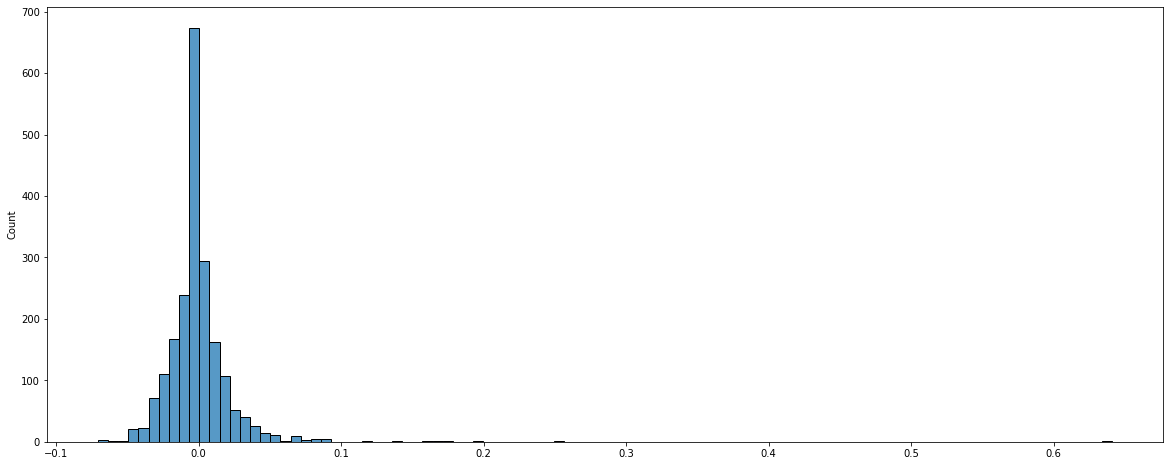

In [15]:
# plot a histogram of the distribution of the weights
sns.histplot(relevant_weights, bins=100)
None

Most weights are close to zero, but there are a few that are much larger.  
Large negative weights are very rare.

In [16]:
# look at the features related to the largest weights
important_features = ordering[:5]
important_features

array([1594,  523, 1668, 1030, 1015])

In [17]:
# display the relevant values
relevant_weights[important_features]

array([0.6412277 , 0.25403914, 0.19300735, 0.17833017, 0.16646281],
      dtype=float32)

In [18]:
# select the main feature to visualise
main_feature = important_features[0]
main_feature

1594

In [19]:
# backtrack to the residual stream
residual_stream = go_backwards(linear_layer, 4)
residual_stream

Tensor("resnet_v2_50/pool5:0", shape=(?, 1, 1, 2048), dtype=float32)
Tensor("resnet_v2_50/postnorm/Relu:0", shape=(?, 7, 7, 2048), dtype=float32)
Tensor("resnet_v2_50/postnorm/FusedBatchNorm:0", shape=(?, 7, 7, 2048), dtype=float32)
Tensor("resnet_v2_50/block4/unit_3/bottleneck_v2/add:0", shape=(?, 7, 7, 2048), dtype=float32)


<tf.Operation 'resnet_v2_50/block4/unit_3/bottleneck_v2/add' type=Add>

In [20]:
# dataset examples that maximise the last feature activation
display(get_images(residual_stream.name, main_feature))

In [21]:
# go back in the residual stream
residual_stream = go_backwards(residual_stream)
residual_stream

Tensor("resnet_v2_50/block4/unit_2/bottleneck_v2/add:0", shape=(?, 7, 7, 2048), dtype=float32)


<tf.Operation 'resnet_v2_50/block4/unit_2/bottleneck_v2/add' type=Add>

In [22]:
# display the dataset examples that maximise the feature activation
display(get_images(residual_stream.name, main_feature))

In [23]:
# go back in the residual stream
residual_stream = go_backwards(residual_stream)
residual_stream

Tensor("resnet_v2_50/block4/unit_1/bottleneck_v2/add:0", shape=(?, 7, 7, 2048), dtype=float32)


<tf.Operation 'resnet_v2_50/block4/unit_1/bottleneck_v2/add' type=Add>

In [24]:
# display the dataset examples that maximise the feature activation
display(get_images(residual_stream.name, main_feature))

In [25]:
# find the shortcut
shortcut = go_backwards(residual_stream, 2)
weights = get_tensor(shortcut.inputs[1].name)
weights.shape

Tensor("resnet_v2_50/block4/unit_1/bottleneck_v2/shortcut/BiasAdd:0", shape=(?, 7, 7, 2048), dtype=float32)
Tensor("resnet_v2_50/block4/unit_1/bottleneck_v2/shortcut/Conv2D:0", shape=(?, 7, 7, 2048), dtype=float32)


(1, 1, 1024, 2048)

The residual stream changes shape here so the shortcut is a matrix to map from the previous shape to the new one.  
These connections seem to matter less than the simple add that happens between most layers.

695

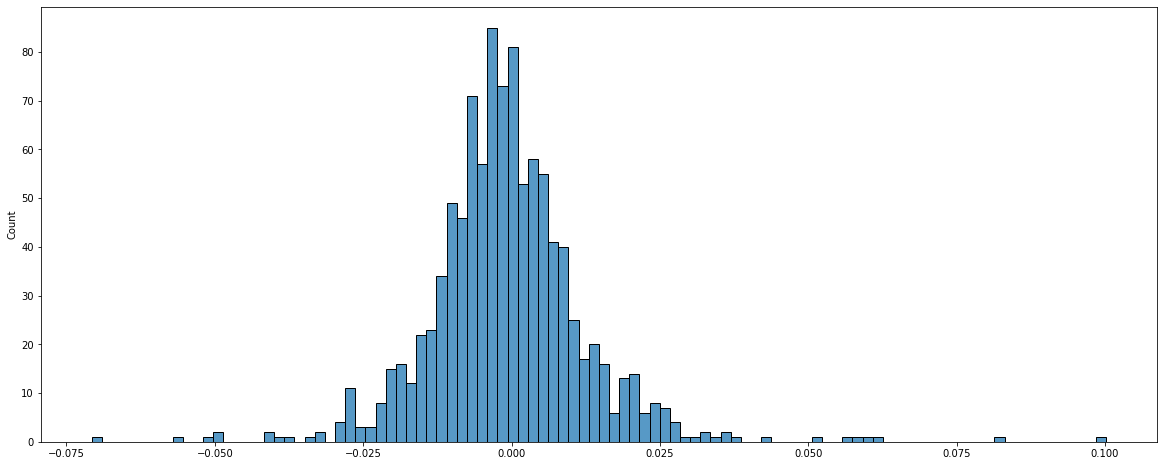

In [26]:
# plot distribution of weights going into the main feature
feature_weights = weights[0, 0, :, main_feature]
sns.histplot(feature_weights, bins=100)
main_feature = feature_weights.argmax()
main_feature

In [27]:
# display the dataset examples that maximise the feature going backwards in the network
residual_stream = shortcut
for _ in range(6):
    residual_stream = go_backwards(residual_stream)
    while not residual_stream.name.endswith("add"):
        residual_stream = go_backwards(residual_stream)
    display(get_images(residual_stream.name, main_feature))

Tensor("resnet_v2_50/block4/unit_1/bottleneck_v2/preact/Relu:0", shape=(?, 7, 7, 1024), dtype=float32)
Tensor("resnet_v2_50/block4/unit_1/bottleneck_v2/preact/FusedBatchNorm:0", shape=(?, 7, 7, 1024), dtype=float32)
Tensor("resnet_v2_50/block3/unit_6/bottleneck_v2/add:0", shape=(?, 7, 7, 1024), dtype=float32)


Tensor("resnet_v2_50/block3/unit_6/bottleneck_v2/shortcut/MaxPool:0", shape=(?, 7, 7, 1024), dtype=float32)
Tensor("resnet_v2_50/block3/unit_5/bottleneck_v2/add:0", shape=(?, 14, 14, 1024), dtype=float32)


Tensor("resnet_v2_50/block3/unit_4/bottleneck_v2/add:0", shape=(?, 14, 14, 1024), dtype=float32)


Tensor("resnet_v2_50/block3/unit_3/bottleneck_v2/add:0", shape=(?, 14, 14, 1024), dtype=float32)


Tensor("resnet_v2_50/block3/unit_2/bottleneck_v2/add:0", shape=(?, 14, 14, 1024), dtype=float32)


Tensor("resnet_v2_50/block3/unit_1/bottleneck_v2/add:0", shape=(?, 14, 14, 1024), dtype=float32)


These generally seem to be less relevant to the class, suggesting there is an important change between these two layers.